# Library

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import normaltest
from scipy.stats import kruskal
import category_encoders as ce
from sklearn.compose import ColumnTransformer
import plotly.express as px


# Data

In [63]:
car_models = ['audi', 'bmw', 'cclass', 'focus', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
df = pd.DataFrame()

for i in car_models:
    carmodel_df = pd.read_csv('dataset/'+i+'.csv')
    if i == 'hyundi':
        carmodel_df = carmodel_df.rename(columns={'tax(£)': 'tax'})

    carmodel_df['brand']=i
    df = pd.concat([df, carmodel_df])
    

In [64]:
# reset ulang index, karena index masih menggunakan index dataframe sebelum digabung
df = df.reset_index()

In [65]:
# drop index lama
df = df.drop(columns='index')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw


- model = tipe mobil.
- year = tahun produksi mobil.
- price = nilai harga jual mobil.
- transmission = tipe transmisi dari mobil.
- mileage = total jarak yang telah ditempuh oleh mobil.
- fuelType = jenis bahan bakar yang digunakan pada mobil.
- tax = nilai pajak mobil.
- mpg = miles per gallon; total jarak tempuh mobil berdasarkan total konsumsi bahan bakar yg digunakan. semakin besar nilai mpg berarti konsumsi bahan bakar yg digunakan akan semakin sedikit (semakin irit).
- engine size = engine capacity atau engine displacement (kapasitas mesin); volume total silinder mesin. secara umum, semakin besar nilai kapasitas mesin akan meningkatkan kebutuhan konsumsi bahan bakar (kendaraan akan semakin boros).

# EDA

## Deskripsi Statistik

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 7.5+ MB


In [6]:
df.describe(include=object)

,model,transmission,fuelType
count,108540,108540,108540
unique,195,4,5
top,Focus,Manual,Petrol
freq,10042,61308,59875


In [18]:
df.isna().sum() / df.shape[0] * 100

model           0.000000
year            0.000000
price           0.000000
transmission    0.000000
mileage         0.000000
fuelType        0.000000
tax             8.627936
mpg             8.627936
engineSize      0.000000
dtype: float64

In [7]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


> dari data diatas, dapat kita lihat bahwa engineSize memiliki nilai minimum 0, dimana hal tersebut tidak mungkin karena tidak ada kendaraan dengan engineSize = 0

## Handling Anomali Data

### Data 'year' = 2060

In [221]:
df[df['year'] == 2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age,transm,fuel
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,-40,2,1


In [222]:
df.drop(df[df['year'] == 2060].index, inplace = True)

In [223]:
df.describe()

,year,price,mileage,tax,mpg,engineSize,age,transm,fuel
count,108539.000000,108539.000000,108539.000000,108539.000000,99186.000000,108539.000000,108539.000000,108539.000000,108539.000000
mean,2017.097633,16890.219820,23025.635661,120.328123,55.166950,1.661646,2.902367,1.664775,1.482942
std,2.126083,9756.260741,21176.301513,60.424977,16.138556,0.557060,2.126083,0.826005,0.569087
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000,0.000000,1.000000,1.000000
25%,2016.000000,10230.000000,7491.500000,114.534548,47.100000,1.200000,1.000000,1.000000,1.000000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000,3.000000,1.000000,1.000000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000,4.000000,2.000000,2.000000
max,2020.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,50.000000,4.000000,5.000000


### Data 'engineSize' = 0

In [10]:
df[df['engineSize'] == 0.0].head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7505,Q5,2019,44790,Automatic,5886,Petrol,135.0,117.7,0.0
7506,Q3,2019,32788,Automatic,1500,Diesel,145.0,47.1,0.0
7516,Q3,2020,29944,Manual,1500,Petrol,145.0,40.9,0.0
7517,Q3,2020,33333,Automatic,1500,Diesel,145.0,47.1,0.0
7518,Q3,2020,29944,Automatic,1500,Petrol,145.0,32.5,0.0


In [11]:
df['engineSize'].unique()

array([1.4, 2. , 1. , 3. , 1.6, 1.8, 1.5, 4. , 2.5, 1.2, 4.2, 2.9, 5.2,
       1.9, 2.7, 0. , 3.2, 4.1, 6.3, 0.6, 4.4, 2.2, 5. , 6.6, 2.8, 3.5,
       2.1, 6.2, 3.6, 5.4, 2.6, 2.3, 1.1, 1.3, 1.7, 2.4, 5.5, 4.7, 6. ,
       3.7, 4.3, 4.5])

In [12]:
totalZeroEngine = df[df['engineSize'] == 0.0]['engineSize'].count()
zeroEnginePersentage = totalZeroEngine / df.shape[0] * 100
print('karena hanya terdapat sebanyak', totalZeroEngine, 'data atau sebesar', round(zeroEnginePersentage, 3), '% dari keseluruhan data, maka data dengan engineSize = 0.0 akan didrop')

karena hanya terdapat sebanyak 286 data atau sebesar 0.263 % dari keseluruhan data, maka data dengan engineSize = 0.0 akan didrop


In [13]:
df = df.drop(df[df['engineSize'] == 0.0].index, axis = 0)

## Missing Value

### Handling Missing Value in Tax

* input Missing Value in Tax menggunakan nilai rata-rata berdasarkan fuelType
* referensi:
    1. https://www.gov.uk/calculate-tax-rates-for-new-cars
    2. https://www.gov.uk/vehicle-tax-rate-tables

In [19]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0
...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2


In [70]:
df['tax']=df['tax'].fillna(df.groupby(['fuelType'])['tax'].transform('mean'))

### Handling Missing Value in MPG

* input Missing Value in MPG menggunakan nilai rata-rata berdasarkan transmission, fuelType, engineSize

In [21]:
df['mpg']=df['mpg'].fillna(df.groupby(['transmission','fuelType','engineSize'])['mpg'].transform('mean'))

In [47]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             7
mpg             3
engineSize      0
dtype: int64

>dikarenakan masih ada data yg bernilai NaN tetapi jumlah data tersebut tidak akan terlalu mempengaruhi keseluruhan data makan data tersebut akan di drop.

In [48]:
df.dropna(inplace=True)

In [49]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108245 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108245 non-null  object 
 1   year          108245 non-null  int64  
 2   price         108245 non-null  int64  
 3   transmission  108245 non-null  object 
 4   mileage       108245 non-null  int64  
 5   fuelType      108245 non-null  object 
 6   tax           108245 non-null  float64
 7   mpg           108245 non-null  float64
 8   engineSize    108245 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 8.3+ MB


## Feature Engineering

### fitur Age

In [174]:
df['age']=2020-df['year']
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,3
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,4
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,4
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,3
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,1
...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,8
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,12
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,11
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,14


### fitur Transm (encode dari fitur transmission)

In [177]:
df['transmission'].unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [180]:
df['transm']=df['transmission'].map({None:0,'Manual':1,'Automatic':2,'Semi-Auto':3,'Other':4})
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age,transm
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,3,1
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,4,2
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,4,1
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,3,2
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,8,1
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,12,1
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,11,1
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,14,1


### fitur Fuel (encode dari fitur fuelType)

In [181]:
df['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'], dtype=object)

In [184]:
df['fuel']=df['fuelType'].map({None:0,'Petrol':1,'Diesel':2,'Hybrid':3,'Other':4,'Electric':5})
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age,transm,fuel
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,3,1,1
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,4,2,2
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,4,1,1
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,3,2,2
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,8,1,2
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,12,1,1
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,11,1,1
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,14,1,1


## Data Visualization (in general)

### Price Distribution

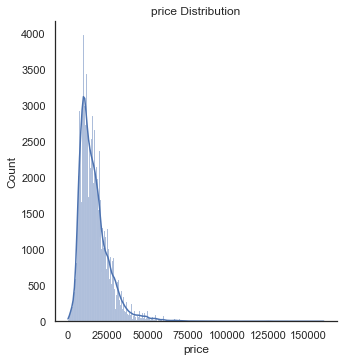

In [323]:
# plt.figure(figsize=(15,8))
sns.displot(df['price'],kde=True) 
plt.title('price Distribution')
plt.show()

### jumlah mobil tiap masing2 tahun

### Percentage of Transmission Type

In [339]:
df_tr=df.groupby('transmission').count()['model'].reset_index()
df_tr= df_tr.rename(columns={'model': 'jumlah'})
df_trPercentage of Transmission Type

,transmission,jumlah
0,Automatic,22318
1,Manual,61308
2,Other,10
3,Semi-Auto,24903


In [430]:
fig = px.pie(df_tr,
            names='transmission',
            values='jumlah',
            title='Percentage of Transmission Type',
            color_discrete_sequence=px.colors.sequential.amp
            )
# fig = go.Figure(data=[go.Pie(labels=df_tr['transmission'], values=df_tr['jumlah'], hole=.65)])
fig.show()

### Percentage of fuelType

In [348]:
df_ft=df.groupby('fuelType').count()['model'].reset_index()
df_ft= df_ft.rename(columns={'model': 'jumlah'})
df_ft

,fuelType,jumlah
0,Diesel,45177
1,Electric,6
2,Hybrid,3229
3,Other,253
4,Petrol,59874


In [395]:
fig = px.pie(df_ft,
            names='fuelType',
            values='jumlah',
            title='Percentage of fuelType',
            color_discrete_sequence=px.colors.sequential.Peach
            )
fig.show()

### Tree Map

In [358]:
model_count=df
ax2= px.treemap(model_count,path=["model"],title='Mobil Bekas Paling Populer:')
ax2.show()

In [437]:
df_treemap = df.groupby(['year','transmission','fuelType']).agg({'model':len,'price':np.mean}).rename(columns={'name':'total'}).reset_index()
df_treemap

,year,transmission,fuelType,model,price
0,1970,Automatic,Diesel,1,24999.000000
1,1970,Manual,Petrol,1,10495.000000
2,1991,Automatic,Petrol,1,4450.000000
3,1995,Automatic,Petrol,1,4750.000000
4,1996,Automatic,Petrol,1,5995.000000
...,...,...,...,...,...
173,2020,Manual,Other,5,20226.400000
174,2020,Manual,Petrol,1423,18174.468025
175,2020,Semi-Auto,Diesel,1022,36690.132094
176,2020,Semi-Auto,Hybrid,106,32677.254717


In [438]:
fig = px.treemap(df_treemap,
                 path=['year','transmission','fuelType'], 
                 values = 'price', 
                 color = 'price',
                 color_continuous_scale='RdBu',
                 color_continuous_midpoint=np.average(df['price'], weights=df['price']),
                 width=1000,
                 height=600,
                 title = "Nilai Rata-Rata price berdasarkan year, transmission, dan fuelType:"
                 )
fig.show()

### Time Series

ref gambar nanti time series:
    
    https://www.moneysupermarket.com/car-insurance/petrol-vs-diesel/?__cf_chl_jschl_tk__=pmd_gyDQZeymIJ8ilTuI76rL9Flxin2tASMb5MaXlCu5JIE-1630055221-0-gqNtZGzNAjujcnBszQi9

## Summary Statistic
(terhadap variabel-variabel yg berpotensi memengaruhi Nilai _price_)

### Cek Normalisasi Data

In [188]:
num_features=list(df.dtypes[df.dtypes!=object].index)
num_features.remove('year')
num_features

['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age', 'transm', 'fuel']

In [193]:
factors = df[num_features]

In [264]:
for i in factors:
    stats,pval=normaltest(factors[i])
    print('Nilai p-Value =',pval)
    if pval <= 0.05:
        print(f'Fitur {i} distribusi tidak normal\n')
    else:
        print(f'Fitur {i} distribusi normal\n')

Nilai p-Value = 0.0
Fitur price distribusi tidak normal

Nilai p-Value = 0.0
Fitur mileage distribusi tidak normal

Nilai p-Value = 0.0
Fitur tax distribusi tidak normal

Nilai p-Value = nan
Fitur mpg distribusi normal

Nilai p-Value = 0.0
Fitur engineSize distribusi tidak normal

Nilai p-Value = 0.0
Fitur age distribusi tidak normal

Nilai p-Value = 0.0
Fitur transm distribusi tidak normal

Nilai p-Value = 0.0
Fitur fuel distribusi tidak normal



### Cek Korelasi Data

In [187]:
num_features=list(df.dtypes[df.dtypes!=object].index)
num_features.remove('year')
num_features

['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age', 'transm', 'fuel']

In [234]:
corr_matrix=df[num_features].corr(method='spearman')
corr_matrix

,price,mileage,tax,mpg,engineSize,age,transm,fuel
price,1.000000,-0.523735,0.302153,-0.393475,0.573605,-0.606475,0.600194,0.274079
mileage,-0.523735,1.000000,-0.277004,0.336628,0.102954,0.813975,-0.156281,0.194017
tax,0.302153,-0.277004,1.000000,-0.576135,0.136746,-0.338726,0.156661,-0.173834
mpg,-0.393475,0.336628,-0.576135,1.000000,-0.206715,0.327662,-0.221402,0.379870
engineSize,0.573605,0.102954,0.136746,-0.206715,1.000000,0.040948,0.515171,0.619718
age,-0.606475,0.813975,-0.338726,0.327662,0.040948,1.000000,-0.185129,0.102634
transm,0.600194,-0.156281,0.156661,-0.221402,0.515171,-0.185129,1.000000,0.276222
fuel,0.274079,0.194017,-0.173834,0.379870,0.619718,0.102634,0.276222,1.000000


* 0-0.3 = weak correlation
* 0.3-0.7 = moderate correlation
* 0.7-1 = strong correlation

* Positive (+) = one variable increases as the other increases the correlation
* Negative (-) = when one decreases as the other increases it
* Complete absence of correlation is represented by 0

Ref: materi Association

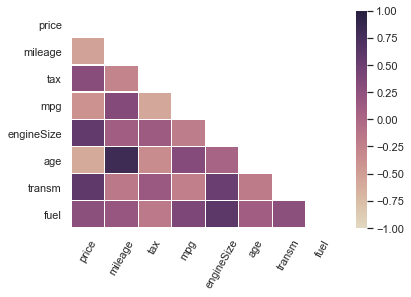

In [432]:
# plt.figure(figsize=(12,8))

sns.set_theme(style="white")

mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

sns.heatmap(corr_matrix,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            linewidths=.2
           )

plt.yticks(rotation=0)
plt.xticks(rotation=60)
plt.show()

### Cek Distribusi Data

In [471]:
kolom=df.columns

In [473]:
len(kolom)

12

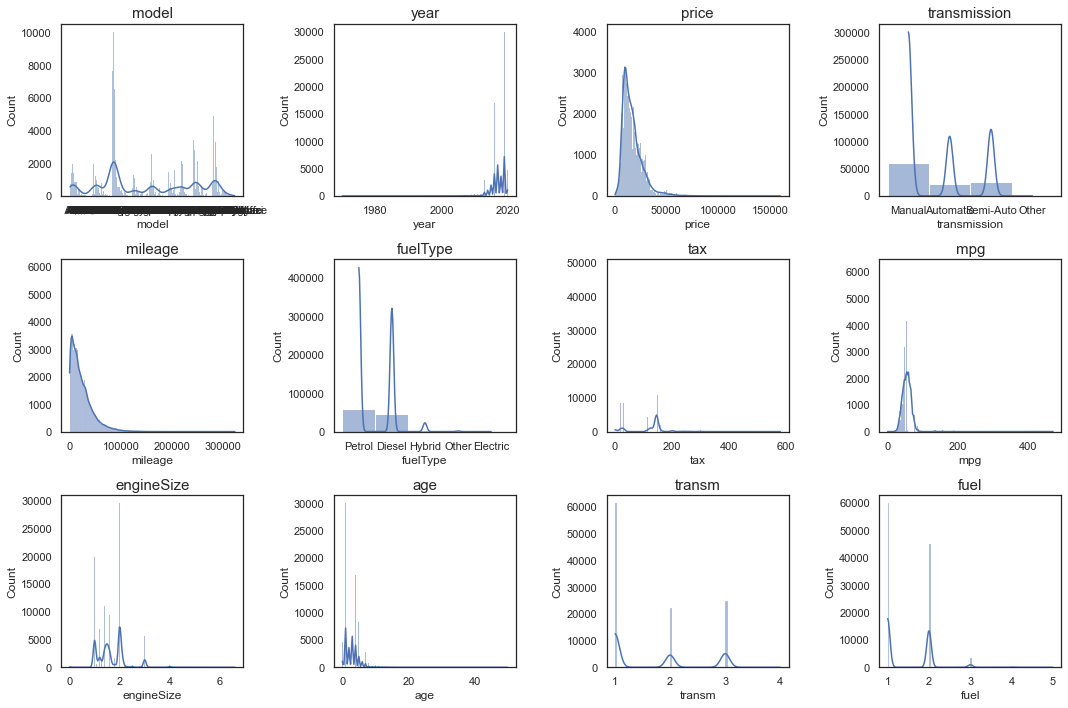

In [489]:
figure, axis = plt.subplots(3,4,figsize=(15,10))

k=0

for i in range(0,3):
    for j in range (0,4):
        axis[i,j].set_title(kolom[k], size=15)
        sns.histplot(ax=axis[i,j], data = df, x=kolom[k], kde=True)
        k+=1

# auto padding subplot
plt.tight_layout()
plt.show()

* berdasarkan histplot, sebaran data feature cenderung *right-skew* kecuali pada data _mpg_
* dapat disimpulkan secara umum persebaran data memiliki distribusi tidak normal.

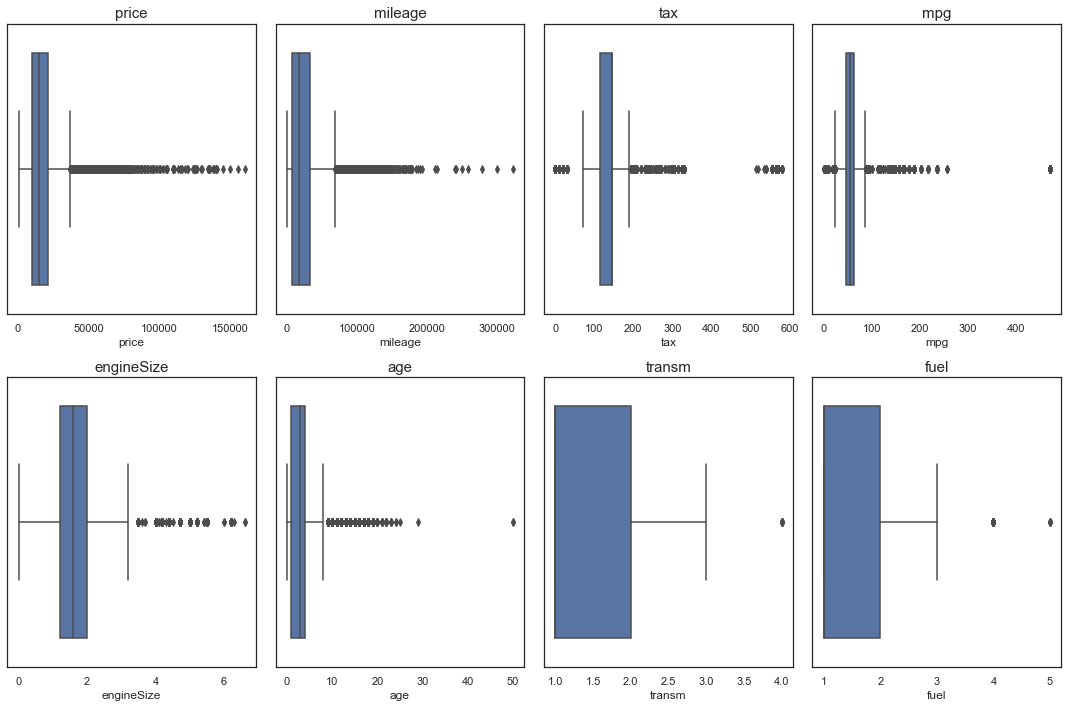

In [487]:
figure, axis = plt.subplots(2,4,figsize=(15,10))

k=0

for i in range(0,2):
    for j in range (0,4):
        axis[i,j].set_title(num_features[k], size=15)
        sns.boxplot(ax=axis[i,j], data = df, x=num_features[k])
        k+=1

# auto padding subplot
plt.tight_layout()
plt.show()

* berdasarkan boxplot, sebaran data feature memiliki banyak outlier di sebelah kanan.
* dapat disimpulkan persebaran data memiliki distribusi tidak normal.

### Uji Analisa

#### Uji 1 : _price_ vs _mileage_

**Korelasi :**

In [237]:
round(df['price'].corr(df['mileage'],method='spearman'),6)

-0.523735

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding terbalik** dengan fitur _mileage_, dimana nilai korelasinya adalah 0.523735 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mileage_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

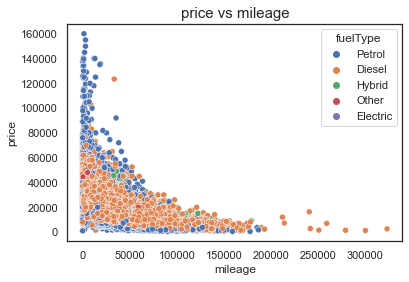

In [238]:
sns.scatterplot(data=df, x='mileage', y='price', hue='fuelType')
plt.title('price vs mileage', size=15)
plt.show()

**Kesimpulan Uji 1 :**

1. Total jarak yg telah ditempuh memiliki pengaruh terhadap penentuan harga jual mobil, dimana semakin tinggi total jarak tempuh yg telah dilakukan mobil maka nilai jual mobil akan semakin rendah.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil yg memiliki harga jual tinggi adalah mobil dengan nilai jarak tempuh yg rendah dengan tipe bahan bakar bakar Petrol.
    * mobil yg memiliki harga jual rendah adalah mobil dengan jarak tempuh yg tinggi dengan tipe bahan bakar Diesel.

#### Uji 2 : _price_ vs _tax_

**Korelasi :**

In [239]:
round(df['price'].corr(df['tax'],method='spearman'),6)

0.302153

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **weak** serta **berbanding Lurus** dengan fitur _tax_, dimana nilai korelasinya adalah 0.302153 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _tax_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

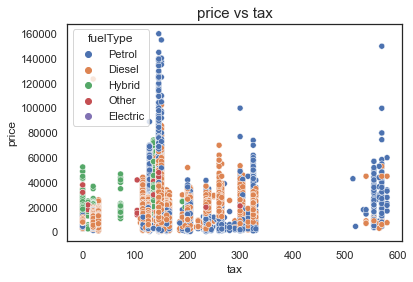

In [246]:
sns.scatterplot(data=df, x='tax', y='price', hue='fuelType')
plt.title('price vs tax', size=15)
plt.show()

**Kesimpulan Uji 2 :**

1. Nilai pajak mobil memiliki pengaruh kecil terhadap penentuan harga jual mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * Mobil dengan jenis bahan bakar _Hybrid_ dan _Other_ memiliki rata-rata nilai _tax_ serta nilai _price_ yg relatif lebih rendah dibandingkan mobil dengan jenis bahan bakar lainnya. 
    * Mobil dengan jenis bahan bakar _Diesel_ memiliki rata-rata nilai _tax_ relatif rendah hingga tinggi tetapi memiliki  nilai _price_ yg relatif tidak terlalu tinggi. 
    * Mobil dengan jenis bahan bakar _Petrol_ memiliki rata-rata nilai _tax_ dan nilai _price_ yg variatif; rendah hingga tinggi.

#### Uji 3 : _price_ vs _mpg_

**Korelasi :**

In [241]:
round(df['price'].corr(df['mpg'],method='spearman'),6)

-0.393475

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **weak** serta **berbanding terbalik** dengan fitur _mpg_, dimana nilai korelasinya adalah 0.393475 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mpg_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

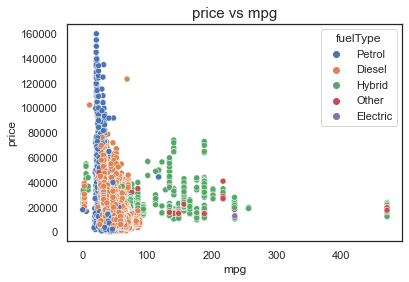

In [301]:
sns.scatterplot(data=df, x='mpg', y='price', hue='fuelType')
plt.title('price vs mpg', size=15)
plt.show()

**Kesimpulan Uji 3 :**

1. Total jarak tempuh mobil berdasarkan total konsumsi bahan bakar yg digunakan memiliki pengaruh kecil terhadap penentuan harga jual mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan tipe bahan bakar bakar Petrol memiliki sebaran nilai mpg yg relatif rendah tetapi memiliki range harga jual yg paling variatif; dari harga paling rendah hingga paling tinggi.
    * mobil dengan tipe bahan bakar bakar Diesel memiliki sebaran nilai mpg yg relatif menengah tetapi memiliki range harga jual yg relatif rendah hingga tidak terlalu tinggi.
    * mobil dengan tipe bahan bakar bakar Hybrid memiliki sebaran nilai mpg yg paling besar tetapi memiliki range harga jual yg relatif tidak terlalu tinggi.

#### Uji 4 : _price_ vs _engineSize_

**Korelasi :**

In [243]:
round(df['price'].corr(df['engineSize'],method='spearman'),6)

0.573605

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Lurus** dengan fitur _engineSize_, dimana nilai korelasinya adalah 0.573605 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _engineSize_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

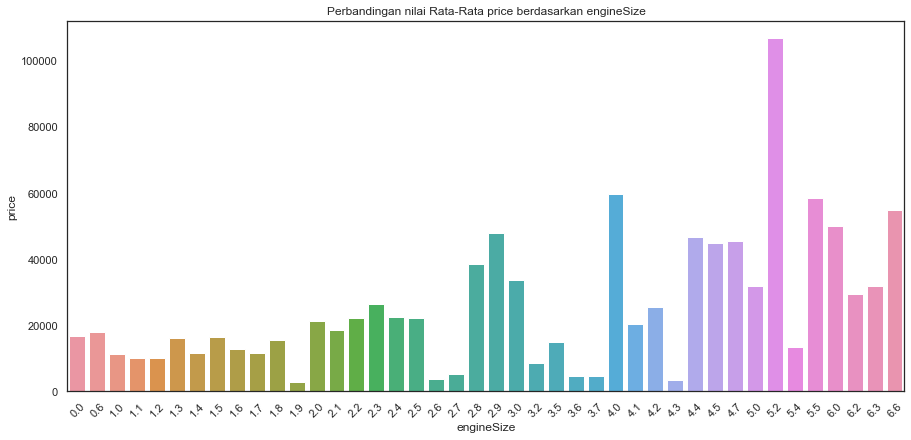

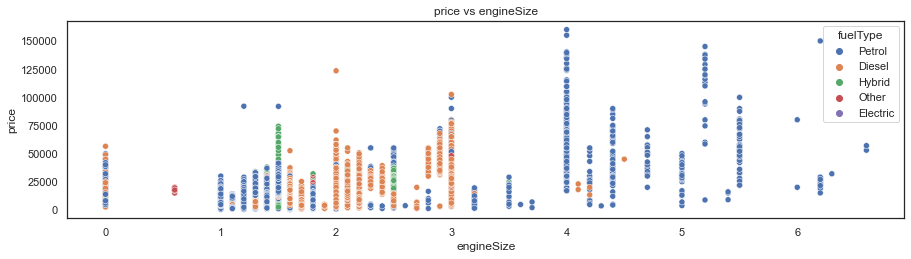

In [299]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

graph=sns.barplot(data=df, x='engineSize', y='price', ci=None)
# for p in graph.patches:
#     height = p.get_height()
#     graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
#                 textcoords='offset points')
# plt.ylim(0, 30000)    
plt.title('Perbandingan nilai Rata-Rata price berdasarkan engineSize')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='engineSize', y='price', hue='fuelType')
plt.title('price vs engineSize') 
plt.show()

**Kesimpulan Uji 4 :**

1. Volume total silinder mesin pengaruh terhadap penentuan harga jual mobil, dimana semakin besar nilai volume total silinder mesin maka nilai jual mobil akan semakin tinggi.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan tipe bahan bakar bakar Petrol memiliki sebaran nilai _engineSize_ dan harga jual yg paling variatif; dari harga paling rendah hingga paling tinggi.
    * mobil dengan tipe bahan bakar bakar Diesel dan Hybrid memiliki sebaran nilai _engineSize_ yg relatif menengah tetapi memiliki range harga jual yg relatif rendah hingga tidak terlalu tinggi.

#### Uji 5 : _price_ vs _age_

Hipotesis:

Ho: rata-rata harga mobil di tiap umur bernilai sama

Ha: rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [248]:
ages=list(df['age'].unique())

In [250]:
stats,pval = kruskal(*[df[df['age'] == i]['price'] for i in ages])

print('Nilai statistic:',stats)
print('Nilai p-value:',pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil di tiap umur bernilai sama.')

Nilai statistic: 42201.4310495591
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Korelasi :**

In [251]:
round(df['price'].corr(df['age'],method='spearman'),6)

-0.606475

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **strong** serta **berbanding Terbalik** dengan fitur _age_, dimana nilai korelasinya adalah 0.60647 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

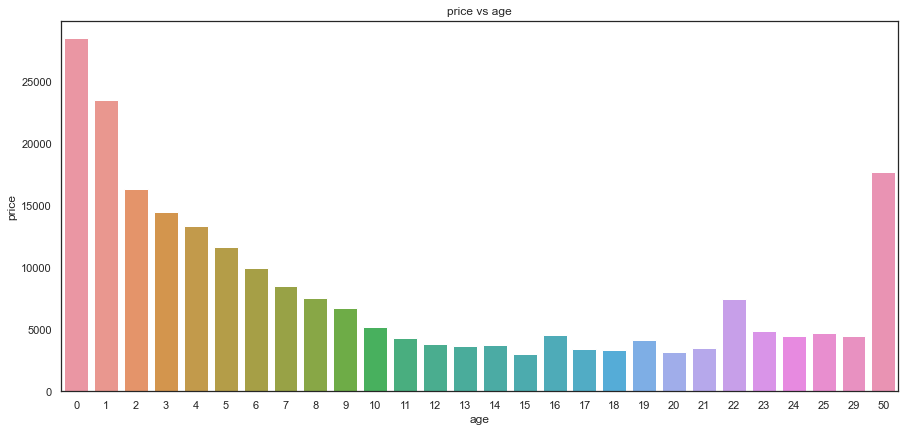

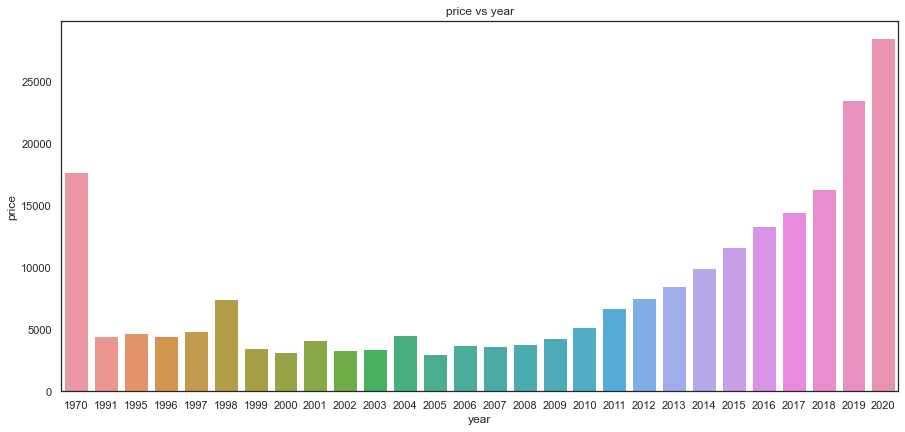

In [258]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.barplot(data=df, x='age', y='price', ci=None)
plt.title('price vs age')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
sns.barplot(data=df, x='year', y='price', ci=None)
plt.title('price vs year')
plt.show()

**Kesimpulan Uji 5 :**

1. Umur beserta tahun produksi mobil memiliki pengaruh besar terhadap penentuan harga jual mobil, dimana semakin muda umur mobil maka semakin mahal harga mobilnya.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan umur 0 tahun atau mobil dengan tahun produksi 2020 memiliki rata-rata harga jual yg lebih tinggi dibanding mobil yg lebih tua atau mobil dengan tahun produksi sebelumnya.
    * mobil dengan umur 50 tahun (tahun produksi 1970) memiliki harga jual yg relatif cukup tinggi jika dibandingkan dengan mobil berumur lainnya, hal ini kemungkinan dikarenakan mobil tersebut merupakan mobil antik / mobil klasik sehingga memiliki nilai historis sebagai variabel perhitungan lain.

#### Uji 6 : _price_ vs _transmission_  (INI MASI AMBIGU)

Hipotesis:

Ho: rata-rata harga mobil tiap tipe transmisi saling bernilai sama 

Ha: rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [101]:
transm=list(df['transmission'].unique())

In [266]:
stats,pval = kruskal(*[df[df['transmission'] == i]['price'] for i in transm])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi saling bernilai sama.')

Nilai statistic: 39717.038046458954
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Korelasi :**

In [481]:
round(df['price'].corr(df['transm'],method='spearman'),6)

0.600194

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **strong** serta **berbanding Lurus** dengan fitur _transmission_, dimana nilai korelasinya adalah 0.600194 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _transmission_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

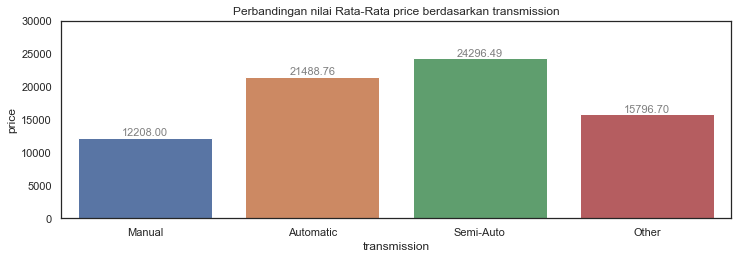

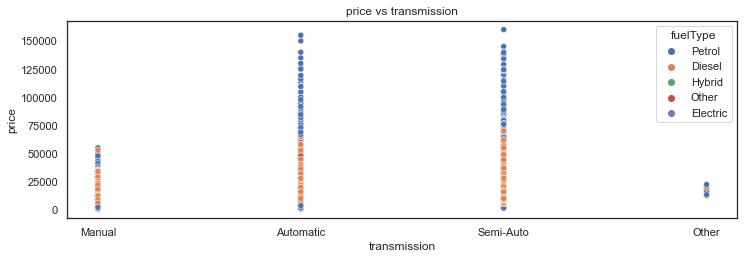

In [276]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)

graph=sns.barplot(data=df, x='transmission', y='price', ci=None)
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 30000)    
plt.title('Perbandingan nilai Rata-Rata price berdasarkan transmission') 
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='transmission', y='price', hue='fuelType')
plt.title('price vs transmission') 
plt.show()

**Kesimpulan Uji 6 :**

1. Jenis transmisi memiliki pengaruh besar terhadap penentuan harga jual mobil, dimana mobil dengan jenis transmisi _Semi-Auto_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan jenis transmisi lainnya sedangkan mobil dengan jenis transmisi _Manual_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan jenis transmisi lainnya.
2. Pada data ini, secara umum digambarkan bahwa sebaran jenis mobil dengan masing-masing jenis bahan bakar terhadap masing-masing tipe transmisi tersebar dengan cukup merata.

#### Uji 7 : _price_ vs _fuelType_ (INI MASI AMBIGU)

Hipotesis:

Ho: rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [103]:
fuel=list(df['fuelType'].unique())

In [265]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['price'] for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 8223.211780826257
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Korelasi :**

In [479]:
round(df['price'].corr(df['fuel'],method='spearman'),6)

0.274079

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **weak** serta **berbanding Lurus** dengan fitur _fuelType_, dimana nilai korelasinya adalah 0.274079 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _fuelType_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

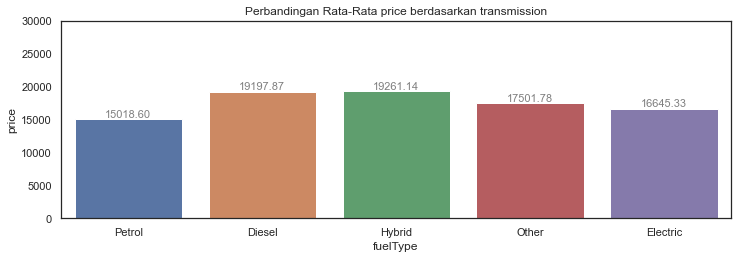

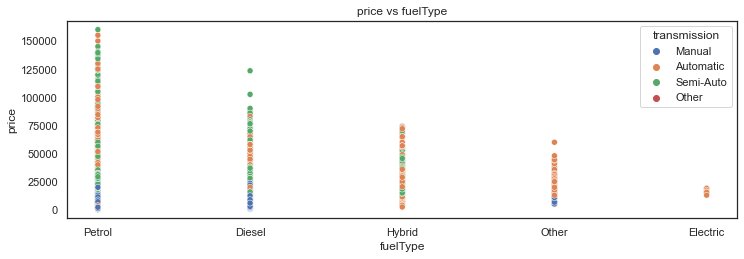

In [272]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)

graph=sns.barplot(data=df, x='fuelType', y='price', ci=None)
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 30000)    
plt.title('Perbandingan Rata-Rata price berdasarkan transmission') 
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='fuelType', y='price', hue='transmission')
plt.title('price vs fuelType') 
plt.show()

**Kesimpulan Uji 7 :**

Jenis transmisi memiliki pengaruh kecil terhadap penentuan harga jual mobil, dimana mobil dengan tipe bahan bakar _Hybrid_ dan _Diesel_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan tipe bahan bakar lainnya sedangkan mobil dengan tipe bahan bakar _Petrol_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan tipe bahan bakar lainnya.

#### Uji 8 : _mpg_ vs _fuel_

**Korelasi :**

In [307]:
round(df['mpg'].corr(df['fuel'],method='spearman'),6)

0.37987

**Analisa Korelasi :**

* Fitur _mpg_ memiliki korelasi **weak** serta **berbanding Lurus** dengan fitur _fuel_, dimana nilai korelasinya adalah 0.37987 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa perbedaan jenis bahan bakar mobil akan dapat memengaruhi nilai _mpg_ dari mobil tersebut.

**Visualisasi :**

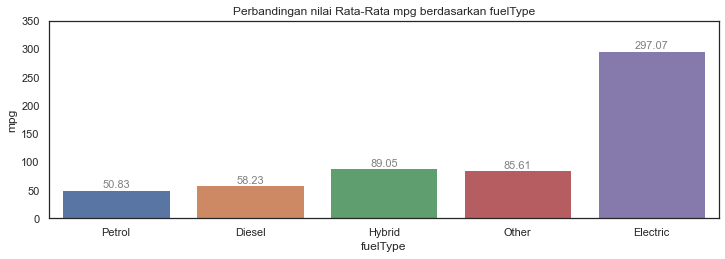

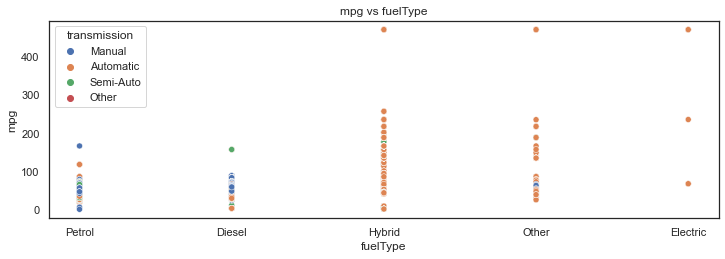

In [483]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)

graph=sns.barplot(data=df, x='fuelType', y='mpg', ci=None)
for p in graph.patches:
    height = p.get_height()
    graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
                textcoords='offset points')
plt.ylim(0, 350)    
plt.title('Perbandingan nilai Rata-Rata mpg berdasarkan fuelType') 
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='fuelType', y='mpg', hue='transmission')
plt.title('mpg vs fuelType') 
plt.show()

**Kesimpulan Uji 8 :**

Jenis bahan bakar yg digunakan oleh suatu mobil dapat memengaruhi nilai _mpg_ nya, dimana mobil dengan jenis bahan bakar Electric memiliki nilai rata-rata _mpg_ yg paling tinggi dibandingkan mobil dengan jenis bahan bakar lainnya dan mobil dengan bahan bakar Petrol memiliki rata-rata nilai _mpg_ yg paling rendah dibanding mobil dengan jenis bahan bakar lainnya.

#### Uji 9 : _mpg_ vs _tax_

**Korelasi :**

In [459]:
round(df['fuel'].corr(df['tax'],method='spearman'),6)

-0.173834

**Analisa Korelasi :**

* Fitur _mpg_ memiliki korelasi **weak** serta **berbanding Terbalik** dengan fitur _tax_, dimana nilai korelasinya adalah 0.173834 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa jenis _fuelType_ mobil akan dapat memengaruhi nilai _tax_ dari mobil tersebut.

**Visualisasi :**

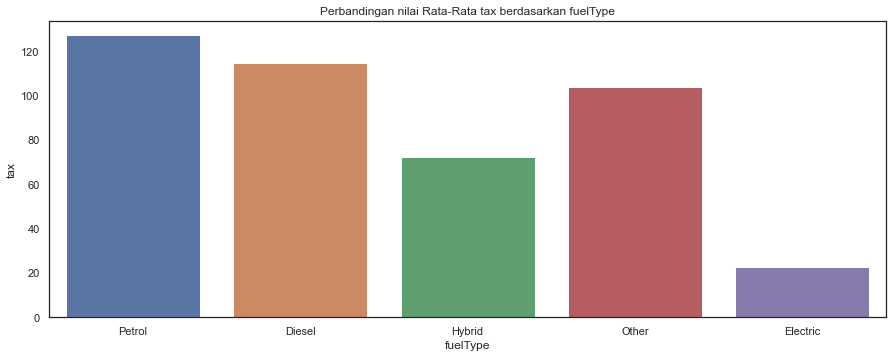

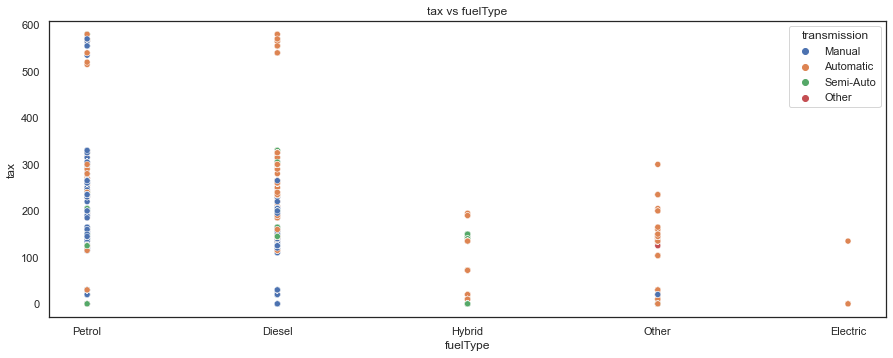

In [466]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)

graph=sns.barplot(data=df, x='fuelType', y='tax', ci=None)
plt.title('Perbandingan nilai Rata-Rata tax berdasarkan fuelType') 
plt.show()

plt.figure(figsize=(15,12))
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='fuelType', y='tax', hue='transmission')
plt.title('tax vs fuelType') 
plt.show()

**Kesimpulan Uji 9 :**

Jenis bahan bakar mobil digunakan dapat memengaruhi nilai _tax_ nya, dimana mobil dengan jenis bahan bakar _Petrol_ memiliki nilai rata-rata _tax_ yg paling tinggi dibandingkan mobil dengan jenis bahan bakar lainnya dan mobil sedangkan bahan bakar _Electric_ memiliki rata-rata nilai _tax_ yg paling rendah dibanding mobil dengan jenis bahan bakar lainnya.

## ke bawah belum diapa2in lagi:
next analisis :
       
* mileage vs age very strong
* tax vs mpg medium
* tax vs age weak
* engineSize vs age medium
* engineSize vs transm medium
* engineSize vs fuel strong

#### Year vs Tax

Hipotesis:

Ho: rata-rata nilai pajak mobil tiap tahun sama

Ha: rata-rata nilai pajak mobil tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [210]:
stats,pval = kruskal(*[df[df['year'] == i]['tax'] for i in years])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai pajak tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai pajak tiap tahun sama.')

Nilai statistic: 20942.03502791971
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai pajak tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


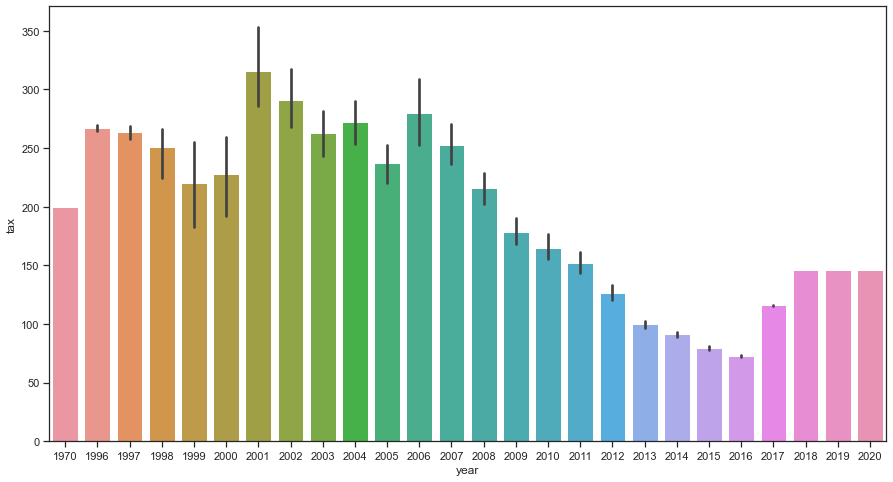

In [60]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='year', y='tax')
plt.show()

>Rata-rata nilai pajak mobil bekas pada tahun 2001 secara umum mulai menurun untuk tahun-tahun berikutnya dan mulai meningkat kembali pada tahun 2017.

<AxesSubplot:xlabel='year', ylabel='count'>

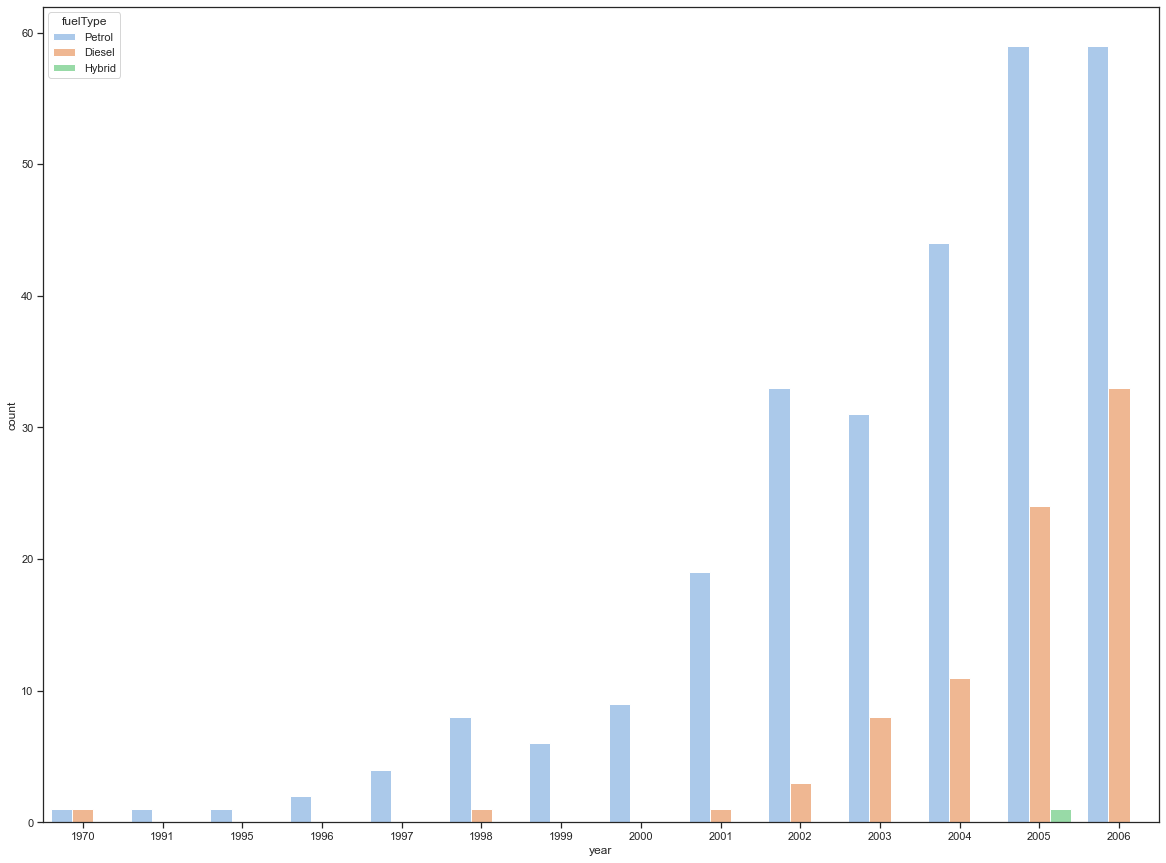

In [74]:
plt.figure(figsize=(20,15))
sns.countplot(x="year", hue="fuelType", data=df[df['year']<2007])

<AxesSubplot:xlabel='year', ylabel='count'>

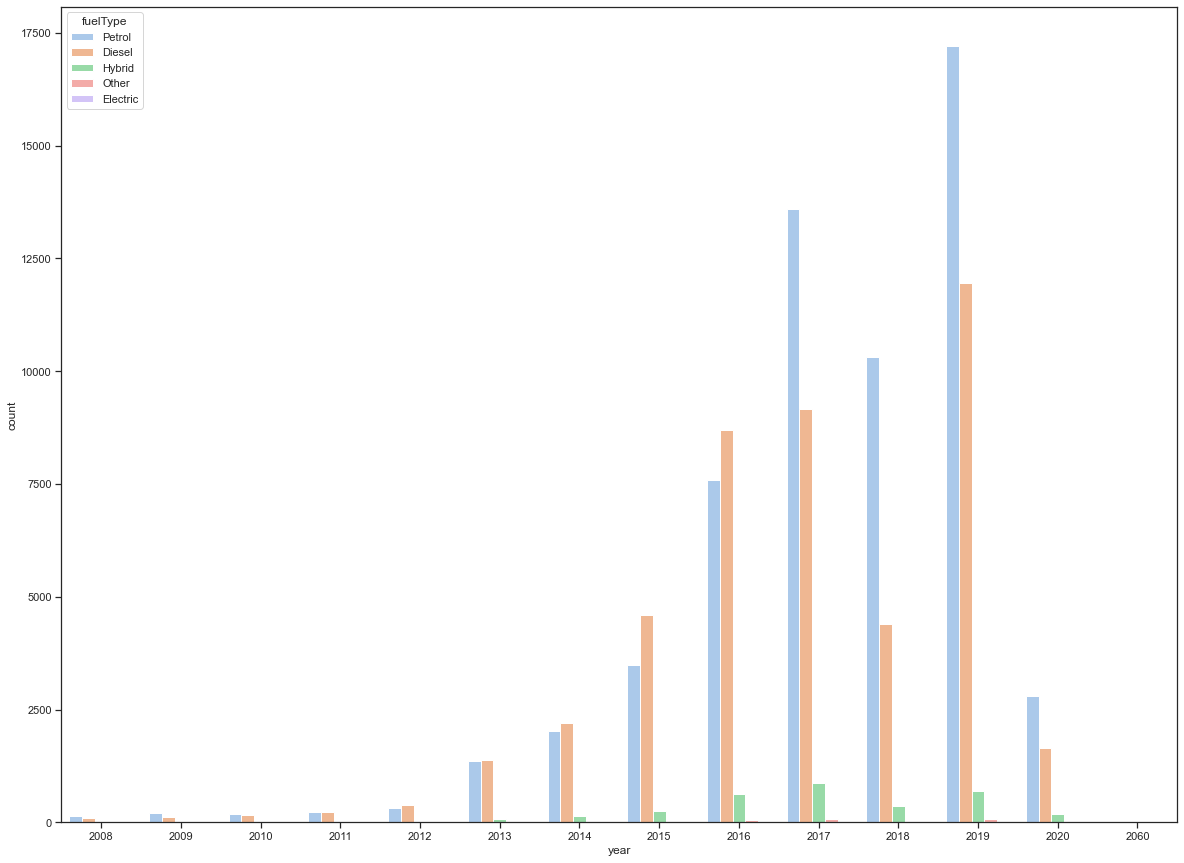

In [75]:
plt.figure(figsize=(20,15))
sns.countplot(x="year", hue="fuelType", data=df[df['year']>2007])

In [113]:
# cat_features=list(df.dtypes[df.dtypes==object].index)
# cat_features.remove('model')
# cat_features

['transmission', 'fuelType']

In [117]:
# pd.get_dummies(df[cat_features])

,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
15152,0,1,0,0,1,0,0,0,0
15153,0,1,0,0,0,0,0,0,1
15154,0,1,0,0,0,0,0,0,1
15155,0,1,0,0,0,0,0,0,1
